# Embedded ML Lab - Challenge (training yolo example)

This is an example of training with the VOC data set and tinyyolov2. Since training tinyyolo from scratch takes a very long time we start with pretrained weights.

In [1]:
import torch

# A subset of VOCDataLoader just for one class (person) (0)
from faf.utils.dataloader import VOCDataLoaderPerson

loader = VOCDataLoaderPerson(train=True, batch_size=128, shuffle=True, path="../data")
loader_test = VOCDataLoaderPerson(train=False, batch_size=1, path="../data")

from faf.tinyyolov2 import TinyYoloV2
from faf.utils.loss import YoloLoss
import tqdm

In [3]:
# We define a tinyyolo network with only two possible classes
net = TinyYoloV2(num_classes=1)
sd = torch.load("../weights/voc_pretrained.pt")

#We load all parameters from the pretrained dict except for the last layer
net.load_state_dict({k: v for k, v in sd.items() if not '9' in k}, strict=False)
net.eval()

# Definition of the loss
criterion = YoloLoss(anchors=net.anchors)

#We only train the last layer (conv9)
for key, param in net.named_parameters():
    if any(x in key for x in ['1', '2', '3', '4', '5', '6', '7']):
        param.requires_grad = False

optimizer = torch.optim.Adam(filter(lambda x: x.requires_grad, net.parameters()), lr=0.001)

100%|██████████| 350/350 [01:07<00:00,  5.20it/s]

average precision [0.09151928629157119]


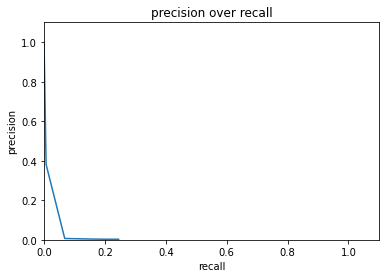

 71%|███████   | 12/17 [00:47<00:19,  3.98s/it]

In [ ]:
from faf.utils.ap import precision_recall_levels, ap, display_roc
from faf.utils.yolo import nms, filter_boxes

NUM_TEST_SAMPLES = 350
NUM_EPOCHS = 15
test_AP = []

for epoch in range(NUM_EPOCHS):
    if epoch != 0:
        for idx, (input, target) in tqdm.tqdm(enumerate(loader), total=len(loader)):

            optimizer.zero_grad()

            #Yolo head is implemented in the loss for training, therefore yolo=False
            output = net(input, yolo=False)
            loss, _ = criterion(output, target)
            loss.backward()
            optimizer.step()

            
    test_precision = []
    test_recall = []
    with torch.no_grad():
        for idx, (input, target) in tqdm.tqdm(enumerate(loader_test), total=NUM_TEST_SAMPLES):
            output = net(input, yolo=True)
            
            #The right threshold values can be adjusted for the target application
            output = filter_boxes(output, 0.0)
            output = nms(output, 0.5)
            
            precision, recall = precision_recall_levels(target[0], output[0])
            test_precision.append(precision)
            test_recall.append(recall)
            if idx == NUM_TEST_SAMPLES:
                break
                
    #Calculation of average precision with collected samples
    test_AP.append(ap(test_precision, test_recall))
    print('average precision', test_AP)

    #plot ROC
    display_roc(test_precision, test_recall)
            
            